In [1]:
#!pip install matplotlib

In [2]:
import vertexai
from vertexai.preview.language_models import TextGenerationModel, ChatModel, CodeGenerationModel
import pandas as pd
from google.cloud import bigquery
import db_dtypes
import base64
from pathlib import Path
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
import uuid  
import os
import time
from retry import retry
import pandas as pd
import numpy as np
from ast import literal_eval
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.prompts import FewShotPromptTemplate, PromptTemplate


In [3]:
def main_fun(ques):

    b = ques

    @retry(tries=2)
    def predict_large_language_model_sample( project_id: str, model_name: str, temperature: float, max_decode_steps: int, top_p: float, top_k: int, content: str, location: str = "us-central1", tuned_model_name: str = "",) :

        """Predict using a Large Language Model."""

        vertexai.init(project=project_id, location=location)

        model = TextGenerationModel.from_pretrained(model_name)

        if tuned_model_name:

          model = model.get_tuned_model(tuned_model_name)

        response = model.predict(content, temperature=temperature, max_output_tokens=max_decode_steps, top_k=top_k, top_p=top_p,)

        #print(f" {response.text}")

        output = response.text
       

        output = output.replace('sql','')
        

        output = output.replace('```','')
        

        return output

        

    data = predict_large_language_model_sample("us-gcp-ame-con-c2aaa-npd-1", "text-bison@001", 0, 962, 0.95, 40, f'''
    
    your_vision: " You are a chatbot for toyota vehicle hold inquary"
    your_mission: " your mission is to provide executable queries from the question {b} "
        
    return only the executable sql query for this question, {b} in bigquery? 
    
    CREATE TABLE ds.vehicle (
        vin STRING,
        modelYear INTEGER,
        brand STRING,
        series STRING,
        modelNumber STRING,
        modelPhaseCode STRING,
        region STRING,
        dealerName STRING,
        dealerCode STRING,
        LifeCyclePhase STRING,
        napCbuIndicator STRING,
        fleetIndicator STRING,
        vehicleHoldIndicator STRING,
        qcHoldIndicator STRING,
        financialHoldIndicator STRING,
        damageHoldIndicator STRING,
        otherHoldIndicator STRING,
        qcNumber STRING,
        modelDescription STRING,
        factoryAccessories STRING,
        interiorTrimColorDescription STRING,
        interiorColorFabricCode STRING,
        interiorTrimDescription STRING,
        interiorColorCode STRING,
        interiorColorDescription STRING,
        exteriorColorName STRING,
        exteriorColorCode STRING,
        productionLockDate DATE,
        dealerInvoiceDate DATE,
        buildDate DATE,
        plantShortDescription STRING,
        plantLongDescription STRING,
        damageDescription STRING,
        
    ) 
    
    Always convert vin, brand, series, modelNumber, region, dealerName to upper case.
    
    Convert vehicleHoldIndicator, qcHoldIndicator, financialHoldIndicator, otherHoldIndicator to camel.
     
    To show the trend of vehicle HoldIndicator, always calculate count(vehicleHoldIndicator) and return the query directly.

    To calculate deviations, always perform absolute difference between first column name from the question and second column name from the question and always apply STDDEV for the predicted absolute difference and return the query directly.
    
    Always give a simple alias name to a column if any operation has been performed on that column.
    
    Configuration details includes FE,CD,CT.
    
    HoldIndicator includes brand, series, region.
    
    Always consider model as model number and don't include model year.
    
    Consider LifeCyclePhase as Life Cycle Phase. 
    
    Consider fleetIndicator as fleet Indicator. 
    
    Consider vehicleHoldIndicator as vehicle hold indicator or vehicle hold. 
    
    Consider financialHoldIndicator as financial hold indicator or financial hold.
    
    Consider qcHoldIndicator as quality campaign hold indicator or qc hold indicator.
    
    Consider qc as quality campaign. 
    
    Consider damageHoldIndicator as damage hold indicator or damage hold.
    
    Consider otherHoldIndicator as other hold indicator or other hold. 
    
    Consider all the business months and don't do any partition.
    
    Remember that before you answer a question, you must check to see if it compiles with your mission above.

    Question : Are there any new series added in the 202305 Business Month 
    
    Answer : SELECT series_name FROM tmna2.tmna2_table WHERE business_month = 202305 AND NOT EXISTS ( SELECT series_name FROM tmna2.tmna2_table WHERE business_month < 202305 ) 
    
    Question : Are there any series discontinued in the 202301 Business Month 
    
    Answer : SELECT series_name FROM tmna2.tmna2_table WHERE business_month < 202301 AND NOT EXISTS ( SELECT series_name FROM tmna2.tmna2_table WHERE business_month >= 202301 )
    
    Always do AVG(overall_acceptance),AVG(ppr1_acceptance),AVG(ppr2_acceptance),AVG(ppr3_acceptance),AVG(target_acceptance)

    Lets think step by step and return only the sql query.
          
    ''', "us-central1")

    #dict_sql = str(data.to_dict())

    #print(data)
    
    return data


In [4]:
question="How many VINs are associated with a quality campaign? "
question=question.lower()
if "business" in question:
    question=question+" and show the business month"
if "region" in question:
    question=question+" and show the region"
if "series" in question:
    question=question+" and show the series at first"
if "brand" in question:
    question=question+" and show the brand"
if "how many" in question:
    question=question+" and show count"
print(question)
result = main_fun(question)
print(result)


how many vins are associated with a quality campaign?  and show count


SELECT count(DISTINCT vin) FROM ds.vehicle WHERE qcHoldIndicator = 'Y'


In [5]:
def run_sql_query(sql):
    # Create a BigQuery client

    client = bigquery.Client()

        # Get the list of tables in the dataset

    tables = client.list_tables('ds')

    results = client.query(sql).to_dataframe()

    return results

In [6]:
result1=run_sql_query(result)


In [7]:
print(result1)

   f0_
0  431


In [8]:
parameters = {

    "temperature": 0,

    "max_output_tokens": 1024,


}

In [9]:
@retry(tries=2)
def table_to_text(question,ans):
    model=TextGenerationModel.from_pretrained(model_name='text-bison@001')
    instruction = """ Given a table and a question. 
    
    convert the ans table to a human readable text sentence according to the question.
    
    """
    result=model.predict(f'''{instruction},
                    question:{question},
                     ans:{ans} 
                     ''',**parameters)
    data=result.text
    return data

In [10]:
sentence1=table_to_text(question,result1)
print(sentence1)

There are 431 vins associated with a quality campaign.


In [11]:
result1.to_csv('data.csv')
result1.to_csv('ans.csv')

In [13]:
!pip install streamlit_chat

  Obtaining dependency information for streamlit_chat from https://files.pythonhosted.org/packages/86/f8/26d8429dea8b240f62193fdf4bd36240e2e18d01be50e8f8c0d65491f4b8/streamlit_chat-0.1.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s eta 0:00:0000:0100:01


In [1]:
import streamlit as st
import vertexai
from streamlit_chat import message

#from english2results import get_results
from timeit import default_timer as timer

vertexai.init(project="us-gcp-con-c2aaa-npd-1", location = "us-central1")


In [ ]:
# Hardcoded UserID
USER_ID = "demo"

st.set_page_config(layout="wide")
st.markdown("""
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Roboto&display=swap');
    </style>
    <div style='text-align: center; font-size: 2.5rem; font-weight: 600; font-family: "Roboto"; color: #018BFF; line-height:1; '>Talent Finder Bot</div>
    <div style='text-align: center; font-size: 1.5rem; font-weight: 300; font-family: "Roboto"; color: rgb(179 185 182); line-height:0; '>
        Powered by <svg width="80" height="60" xmlns="http://www.w3.org/2000/svg" id="Layer_1" data-name="Layer 1" viewBox="0 0 200 75"><path d="M39.23,19c-10.58,0-17.68,6.16-17.68,18.11v8.52A8,8,0,0,1,25,44.81a7.89,7.89,0,0,1,3.46.8V37.07c0-7.75,4.28-11.73,10.8-11.73S50,29.32,50,37.07V55.69h6.89V37.07C56.91,25.05,49.81,19,39.23,19Z"/><path d="M60.66,37.8c0-10.87,8-18.84,19.27-18.84s19.13,8,19.13,18.84v2.53H67.9c1,6.38,5.8,9.93,12,9.93,4.64,0,7.9-1.45,10-4.56h7.6c-2.75,6.66-9.27,10.94-17.6,10.94C68.63,56.64,60.66,48.67,60.66,37.8Zm31.15-3.62c-1.38-5.73-6.08-8.84-11.88-8.84S69.5,28.53,68.12,34.18Z"/><path d="M102.74,37.8c0-10.86,8-18.83,19.27-18.83s19.27,8,19.27,18.83-8,18.84-19.27,18.84S102.74,48.67,102.74,37.8Zm31.59,0c0-7.24-4.93-12.46-12.32-12.46S109.7,30.56,109.7,37.8,114.62,50.26,122,50.26,134.33,45.05,134.33,37.8Z"/><path d="M180.64,62.82h.8c4.42,0,6.08-2,6.08-7V20.16h6.89v35.2c0,8.84-3.48,13.4-12.32,13.4h-1.45Z"/><path d="M177.2,59.14h-6.89V50.65H152.86A8.64,8.64,0,0,1,145,46.2a7.72,7.72,0,0,1,.94-8.16L161.6,17.49a8.65,8.65,0,0,1,15.6,5.13V44.54h5.17v6.11H177.2ZM151.67,41.8a1.76,1.76,0,0,0-.32,1,1.72,1.72,0,0,0,1.73,1.73h17.23V22.45a1.7,1.7,0,0,0-1.19-1.68,2.36,2.36,0,0,0-.63-.09,1.63,1.63,0,0,0-1.36.73L151.67,41.8Z"/><path d="M191,5.53a5.9,5.9,0,1,0,5.89,5.9A5.9,5.9,0,0,0,191,5.53Z" fill="#018bff"/><path d="M24.7,47a5.84,5.84,0,0,0-3.54,1.2l-6.48-4.43a6,6,0,0,0,.22-1.59A5.89,5.89,0,1,0,9,48a5.81,5.81,0,0,0,3.54-1.2L19,51.26a5.89,5.89,0,0,0,0,3.19l-6.48,4.43A5.81,5.81,0,0,0,9,57.68a5.9,5.9,0,1,0,5.89,5.89A6,6,0,0,0,14.68,62l6.48-4.43a5.84,5.84,0,0,0,3.54,1.2A5.9,5.9,0,0,0,24.7,47Z" fill="#018bff"/></svg> | 
        <svg height="60" width="120" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><path d="M32.377 26.446h-12.52v3.715h8.88c-.44 5.2-4.773 7.432-8.865 7.432a9.76 9.76 0 0 1-9.802-9.891c0-5.624 4.354-9.954 9.814-9.954 4.212 0 6.694 2.685 6.694 2.685l2.6-2.694s-3.34-3.717-9.43-3.717c-7.755 0-13.754 6.545-13.754 13.614 0 6.927 5.643 13.682 13.95 13.682 7.307 0 12.656-5.006 12.656-12.408 0-1.562-.227-2.464-.227-2.464z" fill="#4885ed"/><use xlink:href="#A" fill="#db3236"/><use xlink:href="#A" x="19.181" fill="#f4c20d"/><path d="M80.628 23.765c-4.716 0-8.422 4.13-8.422 8.766 0 5.28 4.297 8.782 8.34 8.782 2.5 0 3.83-.993 4.8-2.132v1.73c0 3.027-1.838 4.84-4.612 4.84-2.68 0-4.024-1.993-4.5-3.123l-3.372 1.4c1.196 2.53 3.604 5.167 7.9 5.167 4.7 0 8.262-2.953 8.262-9.147V24.292H85.36v1.486c-1.13-1.22-2.678-2.013-4.73-2.013zm.34 3.44c2.312 0 4.686 1.974 4.686 5.345 0 3.427-2.37 5.315-4.737 5.315-2.514 0-4.853-2.04-4.853-5.283 0-3.368 2.43-5.378 4.904-5.378z" fill="#4885ed"/><path d="M105.4 23.744c-4.448 0-8.183 3.54-8.183 8.76 0 5.526 4.163 8.803 8.6 8.803 3.712 0 6-2.03 7.35-3.85l-3.033-2.018c-.787 1.22-2.103 2.415-4.298 2.415-2.466 0-3.6-1.35-4.303-2.66l11.763-4.88-.6-1.43c-1.136-2.8-3.787-5.14-7.295-5.14zm.153 3.374c1.603 0 2.756.852 3.246 1.874l-7.856 3.283c-.34-2.542 2.07-5.157 4.6-5.157z" fill="#db3236"/><path d="M91.6 40.787h3.864V14.93H91.6z" fill="#3cba54"/><defs><path id="A" d="M42.634 23.755c-5.138 0-8.82 4.017-8.82 8.7 0 4.754 3.57 8.845 8.88 8.845 4.806 0 8.743-3.673 8.743-8.743 0-5.8-4.58-8.803-8.803-8.803zm.05 3.446c2.526 0 4.92 2.043 4.92 5.334 0 3.22-2.384 5.322-4.932 5.322-2.8 0-5-2.242-5-5.348 0-3.04 2.18-5.308 5.02-5.308z"/></defs></svg> GenAI
    </div>
""", unsafe_allow_html=True)


In [ ]:
def generate_context(prompt, context_data='generated'):
    context = []
    # If any history exists
    if st.session_state['generated']:
        # Add the last three exchanges
        size = len(st.session_state['generated'])
        for i in range(max(size-3, 0), size):
            context.append(st.session_state['user_input'][i])
            if len(st.session_state[context_data]) > i:
                context.append(st.session_state[context_data][i])
    # Add the latest user prompt
    context.append(str(prompt))
    return context

In [ ]:
# Generated natural language
if 'generated' not in st.session_state:
    st.session_state['generated'] = []
# Neo4j database results
if 'database_results' not in st.session_state:
    st.session_state['database_results'] = []
# User input
if 'user_input' not in st.session_state:
    st.session_state['user_input'] = []
# Generated Cypher statements
#if 'cypher' not in st.session_state:
#    st.session_state['cypher'] = []

In [ ]:
def get_text():
    input_text = st.text_input(
        "Ask away", "", key="input")
    return input_text

In [ ]:
# Define columns
col1, col2 = st.columns([2, 1])

with col2:
    another_placeholder = st.empty()
with col1:
    placeholder = st.empty()
user_input = get_text()

In [ ]:
if user_input:
    start = timer()
    #results = get_results(generate_context(user_input, 'database_results'))
    results = table_to_text(question,result1)
    try:
        #cypher_step = results['intermediate_steps']
        #print('Total Time : {}'.format(timer() - start))
        #if len(cypher_step) > 0 and 'query' in cypher_step[0]:
        #    st.session_state.cypher.append(cypher_step[0]['query'])
        #else :
        #    st.session_state.cypher.append('')
        
        #if len(cypher_step) > 1 and 'context' in cypher_step[1] and len(cypher_step[1]['context']) > 0:
        #    st.session_state.database_results.append(cypher_step[1]['context'][0])
        #else:
        
        st.session_state.database_results.append('')
        
        st.session_state.user_input.append(user_input)
        st.session_state.generated.append(results['result'])
        
    except Exception as ex:
        print(ex)
        st.session_state.user_input.append(user_input)
        st.session_state.generated.append("Could not generate result due to an error or LLM Quota exceeded")
        #st.session_state.cypher.append("")
        st.session_state.database_results.append('{}')

In [ ]:
# Message placeholder
with placeholder.container():
    if st.session_state['generated']:
        size = len(st.session_state['generated'])
        # Display only the last three exchanges
        for i in range(max(size-3, 0), size):
            message(st.session_state['user_input'][i],
                    is_user=True, key=str(i) + '_user')
            message(st.session_state["generated"][i], key=str(i))

In [ ]:
# Generated Cypher statements
with another_placeholder.container():
    if st.session_state['database_results']:
        st.text_area("Latest generated Query statement",
                     st.session_state['database_results'][-1], height=240)

In [ ]:
@retry(tries=2)
def plot_code(ans):
    model=TextGenerationModel.from_pretrained(model_name='text-bison@001')
    instruction = """ Given a table load it into a python dataframe named 'df'.
                      Generate bar graph for string values and line graph for integer or float values.
                      Generate a python code using matplotlib to plot the df in a graph with appropriate x and y labels and title and resize the graph according to the values.
    
                     Do not try to read data.\n """
    result=model.predict(f'''{instruction}
                     ans:{ans} ''',**parameters)
    return result
    
    

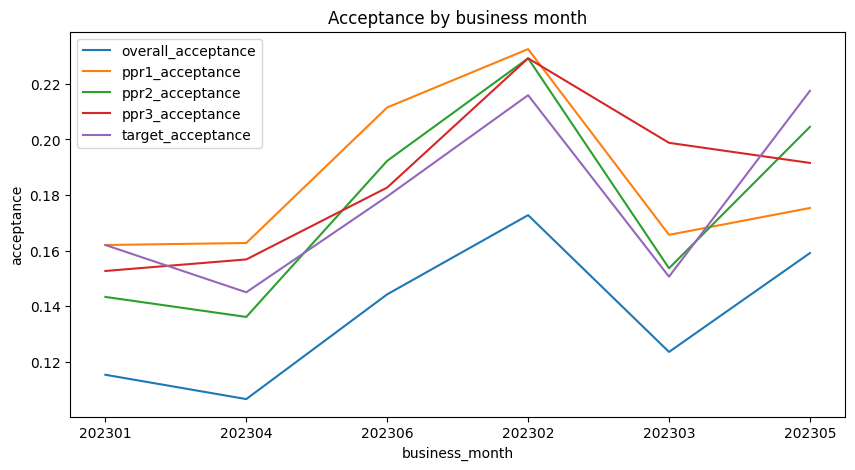

<Figure size 640x480 with 0 Axes>

In [ ]:
#timestamp = time.strftime("%Y%m%d%H%M%S")
#filename = f"image_{timestamp}.png"
#plot_py=str(plot_code(result1))
#plot_py=plot_py.replace('```','').replace('python','')
#exec(plot_py)
#plt.savefig(filename)
#image_path=f'{filename}'


In [ ]:
print(plot_py)


import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'business_month': ['202302', '202302', '202304', '202305', '202306'],
    'region_name': ['SAN FRANCISCO', 'CHICAGO', 'PORTLAND', 'CHICAGO', 'EASTERN'],
    'series_name': ['TACOMA', 'RAV4', 'HIGHLANDER', 'HIGHLANDER', 'COROLLA'],
    'overall_acceptance': [1.00, 1.00, 1.00, 1.00, 0.75]
})

plt.bar(df['region_name'], df['overall_acceptance'])
plt.xlabel('Region Name')
plt.ylabel('Overall Acceptance')
plt.title('Overall Acceptance by Region')
plt.show()



In [ ]:
#print(plot_py)
#with open('./plot_file.py','w+') as f:
#    f.write(str(plot_py))

In [ ]:
#with open("plot_file.py") as f: exec(f.read())

In [ ]:
#exec(open('plot_file.py').read())

In [ ]:
#import matplotlib.pyplot as plt

result = pd.DataFrame({'overall_acceptance': [0.115265, 0.172757, 0.123494, 0.106509, 0.159091, 0.144231], 'business_month': [202301, 202302, 202303, 202304, 202305, 202306]})

plt.plot(result['business_month'], result['overall_acceptance'])
plt.title('Acceptance rate for Region 110')
plt.xlabel('Business Month')
plt.ylabel('Overall Acceptance')
plt.show()

In [ ]:
data = result

# Create a plot
plt.plot(data['business_month'], data['overall_acceptance'])

# Add a title
plt.title('Acceptance rate for Region 110')

# Add labels to the axes
plt.xlabel('Business month')
plt.ylabel('Overall acceptance')
# Show the plot
plt.show()

In [ ]:

#ax = plt.gca()

#result.plot(kind='line',
#        x='business_month',
#        y='overall_acceptance',
#        color='green', ax=ax)
#ax.set_xlabel("Business Months")
#ax.set_ylabel("Overall Acceptance Rate")
#plt.show()


In [ ]:
#from langchain.document_loaders.csv_loader import CSVLoader


#loader = CSVLoader(file_path='TMNA_New_Data_12_july.csv')
#data = loader.load()


In [ ]:
#type(data)

In [ ]:
#from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
#from langchain.document_loaders import TextLoader

#loader = TextLoader('TMNA_New_Data_12_july.csv')
#document=loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 1000,
    chunk_overlap  = 20,
    length_function = len,
    add_start_index = True,
)

In [ ]:
document = text_splitter.split_documents(document)

In [ ]:
from langchain.embeddings.vertexai import VertexAIEmbeddings
from langchain.vectorstores import FAISS

In [ ]:
embeddings = VertexAIEmbeddings()
db = FAISS.from_documents(document, embeddings)